In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
###import os
###! pip install scipy --upgrade
####os.kill(os.getpid(), 9)

In [18]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [19]:
tf.keras.backend.set_floatx("float64")

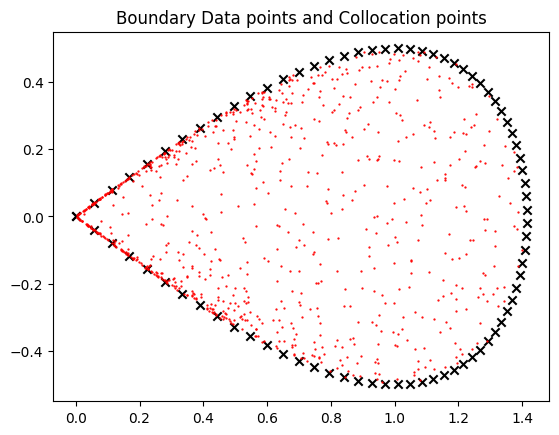

In [20]:
### data generation on boundary ..............
n_bc = 1
n_data_per_bc = 80
theta = np.linspace(np.pi, 3*np.pi,n_data_per_bc)
#
x = np.sqrt(1 + np.cos(theta))
y = 0.5*np.sin(theta)
data = np.zeros([1, n_data_per_bc, 3])
data[0, :, 0] = x 
data[0, :, 1] = y
data[0, :, 2] = 0    
data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

# collocation points ............................
Nc = 870
colloc = np.zeros([Nc, 2]) 
engine = qmc.LatinHypercube(d=2)
points = engine.random(n=Nc)

points[:, 0] = points[:, 0]*2*np.pi  + np.pi
# The power hereafter can be tuned in order to localize more or less where you want ...
colloc[:, 0] = points[:, 1]**0.5 *np.sqrt(1 + np.cos( points[:, 0]))
colloc[:, 1] = points[:, 1]**0.5 * 0.5*np.sin(points[:, 0] )

#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])
#
plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=1.5, marker=".", c="r", label="CP")
plt.show()

#
x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [21]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=7, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [22]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 7, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [23]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [24]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = x*u_xx + x*u_yy - u_x + x*(x*x+1)
    retour = tf.reduce_mean(tf.square(F))
    return retour



In [25]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 3.98010150
  100, 0.54558307
  200, 0.35120745
  300, 0.22890117
  400, 0.17262751
  500, 0.14538637
  600, 0.11656387
  700, 0.08930335
  800, 0.06576619
  900, 0.04526890
 1000, 0.02645935
 1100, 0.01350672
 1200, 0.00969992
 1300, 0.00807835
 1400, 0.00700625
 1500, 0.00625349
 1600, 0.00570817
 1700, 0.00530053
 1800, 0.00498351
 1900, 0.00472485
 2000, 0.00450266
 2100, 0.00430215
 2200, 0.00411330
 2300, 0.00392913
 2400, 0.00374449
 2500, 0.00355525
 2600, 0.00335776
 2700, 0.00314856
 2800, 0.00292448
 2900, 0.00268310
 3000, 0.00242414
 3100, 0.00215173
 3200, 0.00187688
 3300, 0.00161711
 3400, 0.00139044
 3500, 0.00120655
 3600, 0.00106281
 3700, 0.00094803
 3800, 0.00085035
 3900, 0.00076214
 4000, 0.00067998
 4100, 0.00060288
 4200, 0.00053088
 4300, 0.00046432
 4400, 0.00040352
 4500, 0.00034868
 4600, 0.00029978
 4700, 0.00025665
 4800, 0.00021900
 4900, 0.00018646
 5000, 0.00015858
 5100, 0.00013495
 5200, 0.00011509
 5300, 0.00009855
 5400, 0.00008671
 5500, 0.0

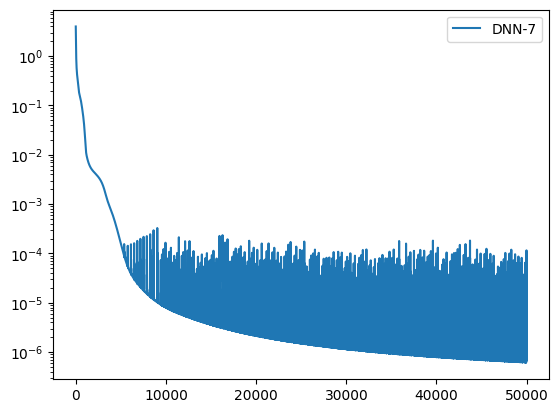

In [26]:
loss = 0
epochs = 50000
opt = tf.keras.optimizers.Adam(learning_rate=2e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])
lp_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = L + l
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    l_values = np.append(l_values, l)
    L_values = np.append(L_values, L)
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.8f}")
        lp_values = np.append(lp_values, loss)

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

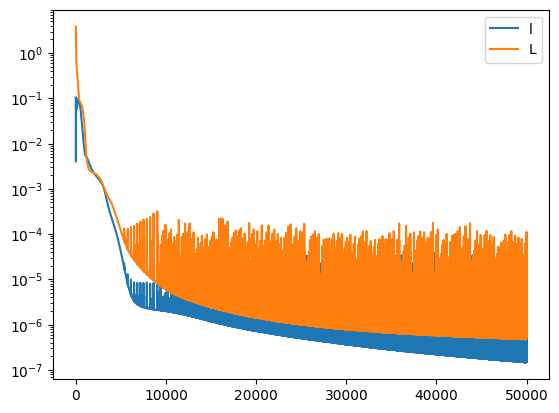

In [27]:
plt.semilogy(l_values, label="l")
plt.semilogy(L_values, label="L")
plt.legend()


n = 200
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

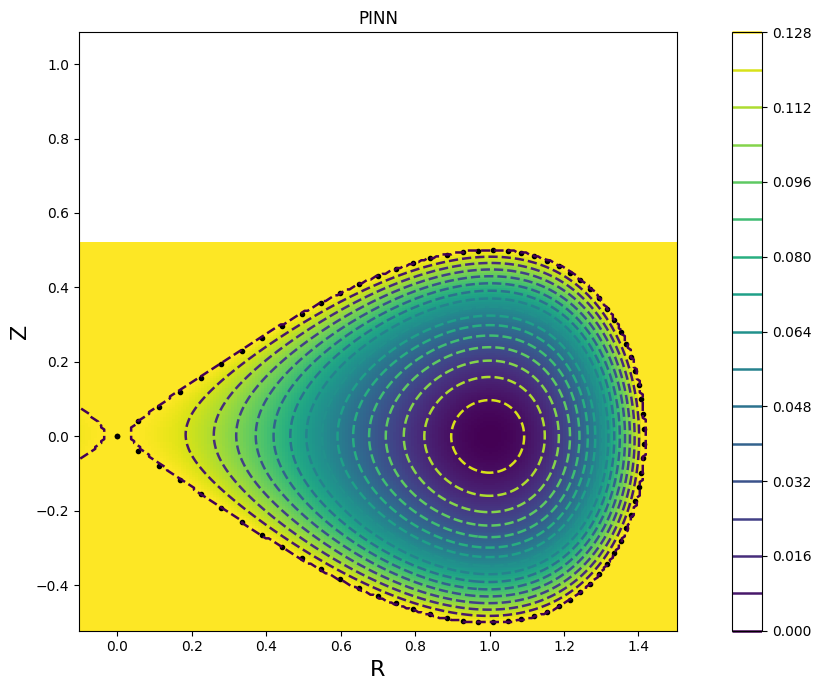

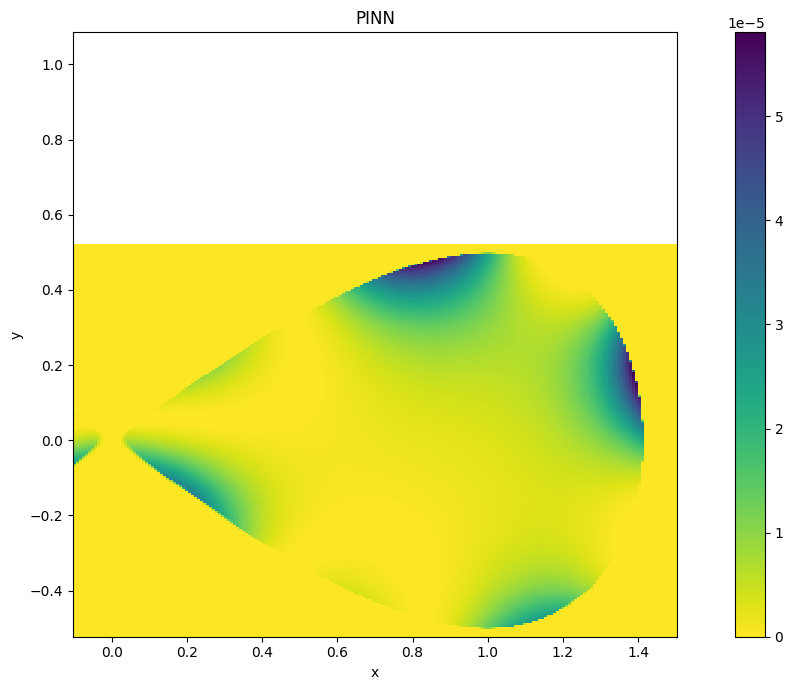

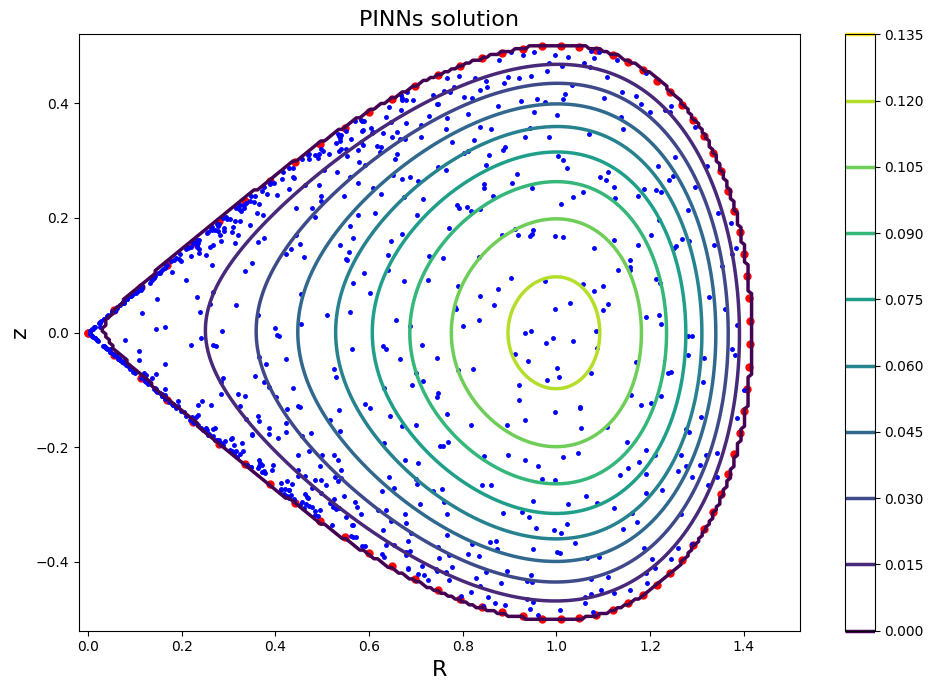

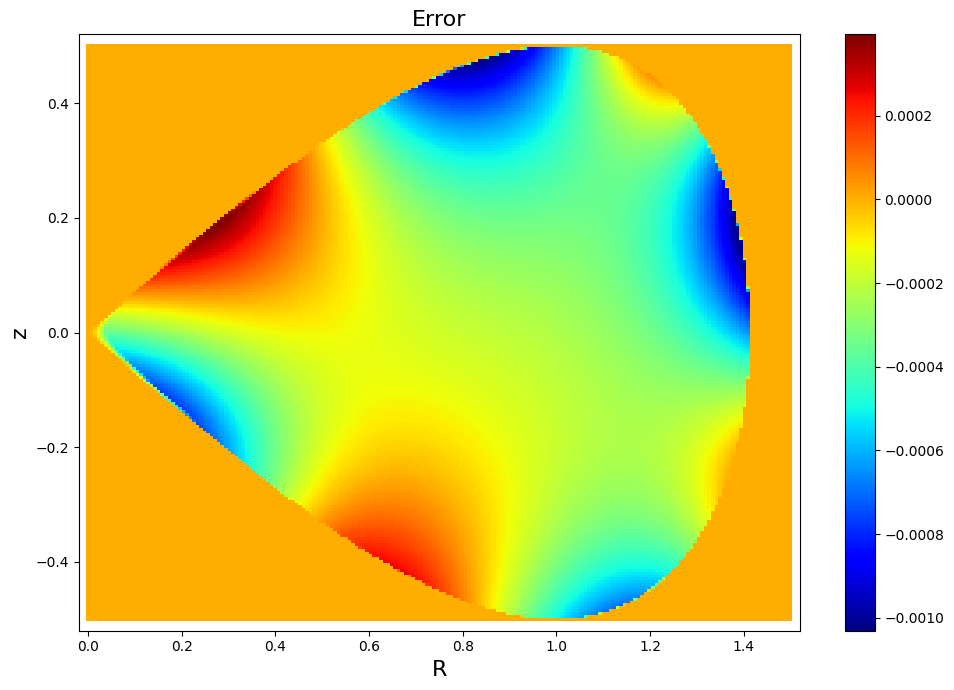

In [28]:
### plotting
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
X = np.linspace(-0.1, +1.5, n)
Y = np.linspace(-0.52, +0.52, n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
S2[S2 < 0] = 0.00000000000000000000
plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
plt.contour(X0, Y0, S2,15,linestyles='dashed',linewidths=1.8)
plt.colorbar(pad=-0.25)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="k", label="BDP")
plt.xlabel("R",fontsize=16)
plt.ylabel("Z",fontsize=16)
plt.xlim(-0.1, 1.6)
plt.ylim(-0.52, 0.52)
plt.title("PINN")
plt.tight_layout()
plt.axis("square")

plt.show()
#



plt.figure("", figsize=(14, 7))
TT = 1/8*(1 - 4*Y0**2 - (2*(X0-1) + (X0-1)**2)**2) 
TT2 = TT
TT2[TT2 < 0] = 0.00000000000000000
err=(TT2-S2)**2/0.135**2

plt.pcolormesh(X0, Y0, err, cmap="viridis_r")

#plt.pcolormesh(X0, Y0, TT2-S2, cmap="viridis_r")

#plt.scatter(colloc[:, 0], colloc[:, 1], s=15.5, marker=".", c="r", label="CP")
#plt.scatter(data[:, 0], data[:, 1], marker=".", c="k", label="BDP")
#plt.contour(X0, Y0, TT2-S2,21)
plt.colorbar(pad=-0.25)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0., 1.5)
plt.ylim(-0.5, 0.5)
plt.title("PINN")
plt.tight_layout()
plt.axis("square")

plt.show()
#


### plotting
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(10, 7))
#
X = np.linspace(-0., +1.5, n)
Y = np.linspace(-0.5, +0.5, n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
S2[S2 < 0] = 0.00000000000000000000
#plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
#plt.contour(X0, Y0, S2,15,linestyles='dashed',linewidths=1.8)
plt.contour(X0, Y0, S2,10,linewidths=2.5)
plt.colorbar(pad=+0.05)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r",s=100, label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=25, marker=".", c="b", label="CP")
plt.xlabel("R",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-0.02, 1.52)
plt.ylim(-0.52, 0.52)
plt.title("PINNs solution",fontsize=16)
plt.tight_layout()
#plt.axis("square")

plt.show()
#



plt.figure("", figsize=(10, 7))
TT = 1/8*(1 - 4*Y0**2 - (2*(X0-1) + (X0-1)**2)**2) 
TT2 = TT
TT2[TT2 < 0] = 0.00000000000000000
#err=(-TT2+S2)**2/0.128**2
err = S2 - TT2
plt.pcolormesh(X0, Y0, err,cmap="jet")

#plt.pcolormesh(X0, Y0, TT2-S2, cmap="viridis_r")

#plt.scatter(colloc[:, 0], colloc[:, 1], s=15.5, marker=".", c="r", label="CP")
#plt.scatter(data[:, 0], data[:, 1], marker=".", c="k", label="BDP")
#plt.contour(X0, Y0, TT2-S2,21)
plt.colorbar(pad=+0.05)
plt.xlabel("R",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-0.02, 1.52)
plt.ylim(-0.52, 0.52)
plt.title("Error",fontsize=16)
plt.tight_layout()
#plt.axis("square")

plt.show()
#






